In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle,Circle

from quantum import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Set up system

In [3]:
def get_density_EVs(h,J,β,N):
    
    k = np.arange(N)+1

    λk = h - 2*J*np.cos(k*np.pi/(N+1))
    Nk = 1/(1+np.exp(β*λk))

    σ1xσ2x = -4/(N+1)*np.sum(np.sin(k*np.pi/(N+1))*np.sin(2*k*np.pi/(N+1))*Nk)
    σ1z = -1+4/(N+1)*np.sum(np.sin(k*np.pi/(N+1))**2*Nk)
    σ2z = -1+4/(N+1)*np.sum(np.sin(2*k*np.pi/(N+1))**2*Nk)
    σ1zσ2z = σ1z*σ2z-σ1xσ2x**2

    δ = np.sqrt(4*σ1xσ2x**2+(σ1z-σ2z)**2)
    p1 = (1 + σ1z + σ2z + σ1zσ2z)/4
    p2 = (1 - δ - σ1zσ2z)/4
    p3 = (1 + δ - σ1zσ2z)/4
    p4 = (1 - σ1z - σ2z + σ1zσ2z)/4
    
    return np.array([p1,p2,p3,p4])



def get_Hmf_EVs(h,J,β,N):
    
    k = np.arange(N)+1
    λk = h - 2*J*np.cos(k*np.pi/(N+1))
    
    NS = 2
    NB = N-NS
    
    kB = np.arange(NB)+1
    λkB = h - 2*J*np.cos(kB*np.pi/(NB+1))
    
    # note the sign difference
    logZ = (β*N*h/2) + np.sum(np.logaddexp(0,-β*λk))
    logZB = (β*NB*h/2) + np.sum(np.logaddexp(0,-β*λkB))
        
    ρEVs = get_density_EVs(h,J,β,N)

    return -1/β*np.log(ρEVs) - 1/β*(logZ-logZB)

In [4]:
s = 1/2
M = int(2*s+1)

N = 20
n = M**N

In [5]:
J = 1
h = .3*J

Jz_T_base = h*np.ones(N)
J_T_base = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if np.abs(i-j)==1: # horizontal neighbor
            J_T_base[i,j] = J
            
N_S = 2
N_B = N - N_S

S_idx = [0,1]
B_idx = np.setdiff1d(np.arange(N),S_idx)

In [12]:
n_ave = 100
k = 30
n_trials = 100

βs = 1/np.logspace(-2.6,3,80)


permute = np.hstack([S_idx,B_idx])
permute_inv = np.argsort(permute)
J_T = J_T_base[np.ix_(permute,permute)]
Jz_T = Jz_T_base[permute]

J_B,J_S,J_I,Jz_B,Jz_S,Jz_I = get_connection_matrix(J_T,Jz_T,N_S)
H_T,H_S,H_B,H_I,H_S_iso,H_B_iso = get_hamiltonians(J_T,Jz_T,N_S,s,method='explicit')

# get base energy. This is used to avoid numerical overflow at low temperature
E0,_ = sp.sparse.linalg.eigsh(H_T,1,which='SA')


EVs = np.zeros((n_trials,len(βs),M**N_S))
for i in range(n_trials):
    clear_output(wait=True)
    print(f'problem: {n_ave}, {k}, {i}/{n_trials}')

    s_print = 1
    trB_expH_T,tr_expH_B,trB_H_I = get_partial_traces(H_T,H_T,H_B_iso,βs,k,n_ave,M,N,N_S,N_B,E0,s_print)

    for l,β in enumerate(βs):
        try:
            EVs[i,l] = np.linalg.eigvalsh(trB_expH_T[l]/tr_expH_B[l])
        except:
            pass

problem: 100, 30, 1/100


In [26]:
np.save('chain_error_EVs',EVs)

In [13]:
ρmf_EVs_theory = np.zeros((len(βs),4))
for i,β in enumerate(βs):
    ρmf_EVs_theory[i] = get_density_EVs(h,J,β,N)

<ipython-input-3-9b79842035ca>:6: RuntimeWarning: overflow encountered in exp
  Nk = 1/(1+np.exp(β*λk))


In [14]:
Hmf_EVs_theory = np.zeros((len(βs),4))
for i,β in enumerate(βs):
    Hmf_EVs_theory[i] = get_Hmf_EVs(h,J,β,N)

<ipython-input-3-9b79842035ca>:6: RuntimeWarning: overflow encountered in exp
  Nk = 1/(1+np.exp(β*λk))


In [15]:
E0,ψ0 = sp.sparse.linalg.eigsh(H_T,1,which='SA')
ρ0 = np.zeros((M**N_S,M**N_S))
for m in range(M**N_S):
    for n in range(M**N_S):
        ρ0[m,n] = (ψ0[m*M**N_B:(m+1)*M**N_B].conj().T@ψ0[n*M**N_B:(n+1)*M**N_B])[0,0]
        
ρEVs_lt = np.linalg.eigvalsh(ρ0)

E0B,_ = sp.sparse.linalg.eigsh(H_B_iso,1,which='SA')

<ipython-input-15-96d934429b34>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  ρ0[m,n] = (ψ0[m*M**N_B:(m+1)*M**N_B].conj().T@ψ0[n*M**N_B:(n+1)*M**N_B])[0,0]


<ipython-input-25-0478db3303ed>:31: RuntimeWarning: invalid value encountered in true_divide
  ρEVs /= np.sum(ρEVs,axis=2)[:,:,None]
<ipython-input-25-0478db3303ed>:68: RuntimeWarning: divide by zero encountered in log
  H_mf_EVs = -1/βs[:,None]*np.log(EVs)


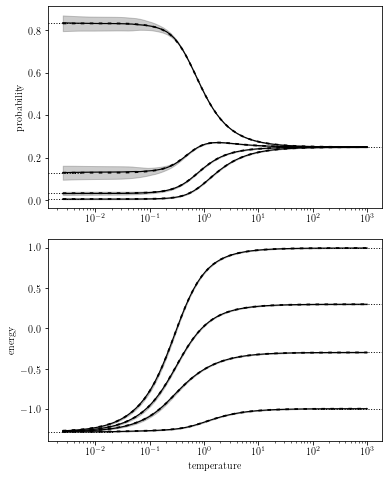

In [25]:
fig,axs = plt.subplots(2,1,figsize=(6,8),gridspec_kw={'height_ratios': [6,6]})
fig.subplots_adjust(hspace=.15)

#axs = [None,axs[0],axs[1]]
if False:
    axs[0].set_aspect('equal')

    for ii in range(N):
        axs[0].add_patch(Circle((ii%N,ii//N),.15/2, facecolor='k',edgecolor=None,zorder=10))
        for jj in range(ii):
            if J_T_base[ii,jj] == 1:
                axs[0].plot([ii%N,jj%N],[ii//N,jj//N],lw=1,color='k')

            for S in S_idx:
                axs[0].add_patch(Circle((S%N,S//N), .25/2, facecolor='None',edgecolor='r',zorder=10))

    axs[0].set_axis_off()
    
    
permute = np.hstack([S_idx,B_idx])
permute_inv = np.argsort(permute)
J_T = np.copy(J_T_base)[np.ix_(permute,permute)]
Jz_T = np.copy(Jz_T_base)[permute]

isolated_EVs = np.linalg.eigvalsh(H_S_iso.A)

#ρEVs_iso = np.exp(-βs[:,None]*isolated_EVs)/np.sum(np.exp(-βs[:,None]*isolated_EVs),axis=1)[:,None]
#axs[0].plot(1/βs,ρEVs_iso,lw=1,ls=':',color='k',label='bare system')

ρEVs = np.copy(EVs)
ρEVs /= np.sum(ρEVs,axis=2)[:,:,None]
ρEVs_med = np.nanquantile(ρEVs,.5,axis=0)

ρEVs_top = np.nanquantile(ρEVs,.9,axis=0)
ρEVs_bot = np.nanquantile(ρEVs,.1,axis=0)


axs[0].plot(1/βs,ρEVs_med,lw=1.2,color='k',label='system in bath')
for j in range(4):
    axs[0].fill_between(1/βs,ρEVs_top[:,j],ρEVs_bot[:,j],color='k',alpha=.2)

for E in ρEVs_lt:
    axs[0].axhline(E,0,.1,lw=1,ls=':',color='k',label='bare system')
axs[0].axhline(1/M**N_S,.8,1,lw=1,ls=':',color='k',label='bare system')


# theoretical limit
axs[0].plot(1/βs,ρmf_EVs_theory,lw=1.8,color='k',ls=(0, (2, 3)),label='theory');
axs[0].set_xscale('log')
    
#handles, labels = axs[0].get_legend_handles_labels()
#unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#axs[0].legend(*zip(*unique))

axs[0].set_xscale('log')
axs[0].set_ylabel('probability')

#axs[0].set_xlabel('temperature')

# ===============
# bottom plot
# ===============

for E in isolated_EVs:
    axs[1].axhline(E,.8,1,lw=1,ls=':',color='k',label='bare system')
axs[1].axhline(E0-E0B,0,.2,ls=':',lw=1,color='k',label='energy difference')

H_mf_EVs = -1/βs[:,None]*np.log(EVs)
H_mf_EVs_med = np.quantile(H_mf_EVs,.5,axis=0)

H_mf_EVs_top = np.quantile(H_mf_EVs,.9,axis=0)
H_mf_EVs_bot = np.quantile(H_mf_EVs,.1,axis=0)

axs[1].plot(1/βs,H_mf_EVs_med,lw=1.2,color='k',label='system in bath')
for j in range(4):
    axs[1].fill_between(1/βs,H_mf_EVs_top[:,j],H_mf_EVs_bot[:,j],color='k',alpha=.2)


# theoretical limit
axs[1].plot(1/βs,Hmf_EVs_theory,lw=1.8,color='k',ls=(0, (2, 3)),label='theory');
axs[1].set_xscale('log')

#handles, labels = axs[1].get_legend_handles_labels()
#unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#axs[1].legend(*zip(*unique))

axs[1].set_xscale('log')
axs[1].set_xlabel('temperature')
axs[1].set_ylabel('energy')


#axs[1].plot(1/βs,-np.sum(ρEVs_med*np.log(ρEVs_med),axis=1))
#axs[1].set_xscale('log')

plt.savefig('spin_imgs/chain_eigs.pdf',bbox_inches='tight')